# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

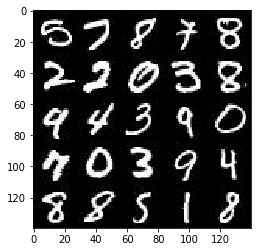

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

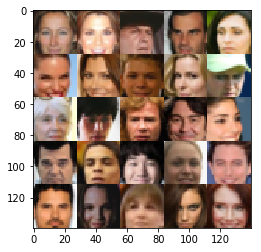

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32,(None, image_width, image_height, image_channels),name='input_real')
    input_z = tf.placeholder(tf.float32,(None,z_dim), name='input_z')
    in_learning_rate = tf.placeholder(tf.float32,None,name='learning_rate')
    return input_real,input_z,in_learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    stddev = 0.02
    with tf.variable_scope('discriminator',reuse=reuse):
        layer_1 = tf.layers.conv2d(images,32,5,2,padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_1 = tf.maximum(alpha*layer_1,layer_1)
        
        layer_2 = tf.layers.conv2d(layer_1,64,5,2,padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_2 = tf.layers.batch_normalization(layer_2,training=True)
        layer_2 = tf.maximum(alpha*layer_2,layer_2)
        
        layer_3 = tf.layers.conv2d(layer_2,128,5,2,padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_3 = tf.layers.batch_normalization(layer_3,training=True)
        layer_3 = tf.maximum(alpha*layer_3,layer_3)
        
        layer_4 = tf.layers.conv2d(layer_1,256,5,2,padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_4 = tf.layers.batch_normalization(layer_4,training=True)
        layer_4 = tf.maximum(alpha*layer_4,layer_4)
        
        flattened = tf.reshape(layer_4,(-1,2*2*256))
        logits = tf.layers.dense(flattened,1,kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.sigmoid(logits)
        
        return output,logits
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [12]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    stddev=0.02
    
    with tf.variable_scope('generator',reuse=not is_train):
        layer_1 = tf.layers.dense(z,7*7*256)
        layer_1 = tf.reshape(layer_1,(-1,7,7,256))
        layer_1 = tf.layers.batch_normalization(layer_1,training=is_train)
        #layer_1 = tf.maximum(alpha*layer_1,layer_1)
        
        layer_2 = tf.layers.conv2d_transpose(layer_1, 128, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        
        layer_3 = tf.layers.conv2d_transpose(layer_2, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        
        #layer_4 = tf.layers.conv2d_transpose(layer_3, 32, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        #layer_4 = tf.layers.batch_normalization(layer_4, training=is_train)
        #layer_4 = tf.maximum(alpha * layer_4, layer_4)
        
        logits = tf.layers.conv2d_transpose(layer_3, out_channel_dim, 5, 1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.tanh(logits)
        
    return output
        
        



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [13]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_logits_real) * 0.9))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_logits_fake)))
    dis_loss = dis_loss_real + dis_loss_fake
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_logits_fake)))
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
        return dis_train_ops, gen_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    dis_ops, gen_ops = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(dis_ops, feed_dict={ input_real: batch_images, input_z: batch_z, in_learning_rate: learning_rate })
                _ = sess.run(gen_ops, feed_dict={ input_z: batch_z, in_learning_rate: learning_rate })
                
                if steps % print_every == 0:
                    dis_loss_train = dis_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    gen_loss_train = gen_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(dis_loss_train),
                         "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2170... Generator Loss: 0.8233
Epoch 1/2... Discriminator Loss: 1.2917... Generator Loss: 0.9570
Epoch 1/2... Discriminator Loss: 1.3734... Generator Loss: 0.8398
Epoch 1/2... Discriminator Loss: 1.3292... Generator Loss: 0.8062
Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 0.8054
Epoch 1/2... Discriminator Loss: 1.3335... Generator Loss: 0.8324
Epoch 1/2... Discriminator Loss: 1.3456... Generator Loss: 0.8385
Epoch 1/2... Discriminator Loss: 1.3376... Generator Loss: 0.8550
Epoch 1/2... Discriminator Loss: 1.3421... Generator Loss: 0.8095
Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.8167


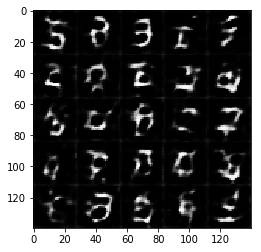

Epoch 1/2... Discriminator Loss: 1.3557... Generator Loss: 0.8238
Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 0.7388
Epoch 1/2... Discriminator Loss: 1.3675... Generator Loss: 0.7729
Epoch 1/2... Discriminator Loss: 1.4060... Generator Loss: 0.7350
Epoch 1/2... Discriminator Loss: 1.3854... Generator Loss: 0.7052
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.7961
Epoch 1/2... Discriminator Loss: 1.3628... Generator Loss: 0.7948
Epoch 1/2... Discriminator Loss: 1.3714... Generator Loss: 0.7815
Epoch 1/2... Discriminator Loss: 1.3627... Generator Loss: 0.7787
Epoch 1/2... Discriminator Loss: 1.3474... Generator Loss: 0.8151


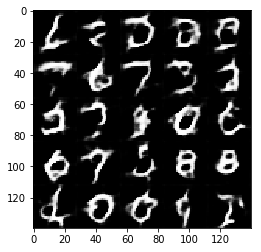

Epoch 1/2... Discriminator Loss: 1.3550... Generator Loss: 0.7655
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.8350
Epoch 1/2... Discriminator Loss: 1.3462... Generator Loss: 0.8224
Epoch 1/2... Discriminator Loss: 1.3527... Generator Loss: 0.8124
Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.7945
Epoch 1/2... Discriminator Loss: 1.3872... Generator Loss: 0.8644
Epoch 1/2... Discriminator Loss: 1.3825... Generator Loss: 0.8763
Epoch 1/2... Discriminator Loss: 1.3517... Generator Loss: 0.8245
Epoch 1/2... Discriminator Loss: 1.3455... Generator Loss: 0.8083
Epoch 1/2... Discriminator Loss: 1.3488... Generator Loss: 0.8208


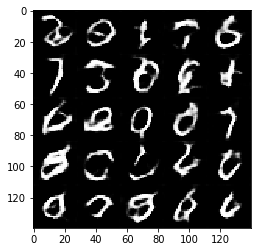

Epoch 1/2... Discriminator Loss: 1.3534... Generator Loss: 0.8083
Epoch 1/2... Discriminator Loss: 1.3582... Generator Loss: 0.9050
Epoch 1/2... Discriminator Loss: 1.3407... Generator Loss: 0.8025
Epoch 1/2... Discriminator Loss: 1.3500... Generator Loss: 0.8065
Epoch 1/2... Discriminator Loss: 1.3839... Generator Loss: 0.8954
Epoch 1/2... Discriminator Loss: 1.3587... Generator Loss: 0.8906
Epoch 1/2... Discriminator Loss: 1.3492... Generator Loss: 0.8096
Epoch 1/2... Discriminator Loss: 1.3539... Generator Loss: 0.8026
Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 0.7780
Epoch 1/2... Discriminator Loss: 1.3422... Generator Loss: 0.8766


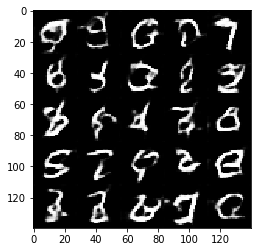

Epoch 1/2... Discriminator Loss: 1.3529... Generator Loss: 0.8177
Epoch 1/2... Discriminator Loss: 1.3303... Generator Loss: 0.8506
Epoch 1/2... Discriminator Loss: 1.4115... Generator Loss: 0.9248
Epoch 1/2... Discriminator Loss: 1.3297... Generator Loss: 0.8655
Epoch 1/2... Discriminator Loss: 1.3246... Generator Loss: 0.8341
Epoch 1/2... Discriminator Loss: 1.3352... Generator Loss: 0.8257
Epoch 2/2... Discriminator Loss: 1.3725... Generator Loss: 0.8018
Epoch 2/2... Discriminator Loss: 1.3384... Generator Loss: 0.8441
Epoch 2/2... Discriminator Loss: 1.3415... Generator Loss: 0.8314
Epoch 2/2... Discriminator Loss: 1.3265... Generator Loss: 0.8794


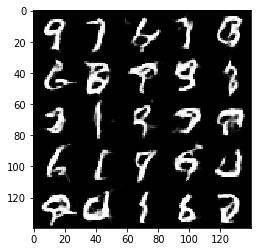

Epoch 2/2... Discriminator Loss: 1.3310... Generator Loss: 0.8412
Epoch 2/2... Discriminator Loss: 1.3547... Generator Loss: 0.7445
Epoch 2/2... Discriminator Loss: 1.4602... Generator Loss: 0.9522
Epoch 2/2... Discriminator Loss: 1.3745... Generator Loss: 0.8618
Epoch 2/2... Discriminator Loss: 1.3401... Generator Loss: 0.8043
Epoch 2/2... Discriminator Loss: 1.3323... Generator Loss: 0.8285
Epoch 2/2... Discriminator Loss: 1.3353... Generator Loss: 0.8126
Epoch 2/2... Discriminator Loss: 1.3157... Generator Loss: 0.8409
Epoch 2/2... Discriminator Loss: 1.3456... Generator Loss: 0.8224
Epoch 2/2... Discriminator Loss: 1.3511... Generator Loss: 0.8370


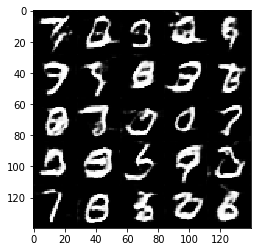

Epoch 2/2... Discriminator Loss: 1.3285... Generator Loss: 0.8028
Epoch 2/2... Discriminator Loss: 1.3463... Generator Loss: 0.7451
Epoch 2/2... Discriminator Loss: 1.3356... Generator Loss: 0.8399
Epoch 2/2... Discriminator Loss: 1.3260... Generator Loss: 0.8840
Epoch 2/2... Discriminator Loss: 1.3483... Generator Loss: 0.8451
Epoch 2/2... Discriminator Loss: 1.3213... Generator Loss: 0.7809
Epoch 2/2... Discriminator Loss: 1.3554... Generator Loss: 0.7300
Epoch 2/2... Discriminator Loss: 1.3574... Generator Loss: 0.8078
Epoch 2/2... Discriminator Loss: 1.3389... Generator Loss: 0.8722
Epoch 2/2... Discriminator Loss: 1.3213... Generator Loss: 0.8201


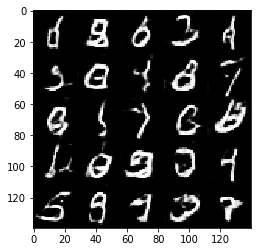

Epoch 2/2... Discriminator Loss: 1.3274... Generator Loss: 0.8800
Epoch 2/2... Discriminator Loss: 1.3399... Generator Loss: 0.8514
Epoch 2/2... Discriminator Loss: 1.3498... Generator Loss: 0.7128
Epoch 2/2... Discriminator Loss: 1.3320... Generator Loss: 0.8194
Epoch 2/2... Discriminator Loss: 1.3135... Generator Loss: 0.8797
Epoch 2/2... Discriminator Loss: 1.3210... Generator Loss: 0.8297
Epoch 2/2... Discriminator Loss: 1.3247... Generator Loss: 0.8769
Epoch 2/2... Discriminator Loss: 1.3312... Generator Loss: 0.8336
Epoch 2/2... Discriminator Loss: 1.3524... Generator Loss: 0.8620
Epoch 2/2... Discriminator Loss: 1.3451... Generator Loss: 0.8008


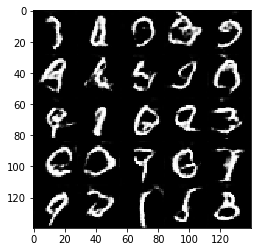

Epoch 2/2... Discriminator Loss: 1.3473... Generator Loss: 0.8563
Epoch 2/2... Discriminator Loss: 1.3707... Generator Loss: 0.9179
Epoch 2/2... Discriminator Loss: 1.3349... Generator Loss: 0.8135
Epoch 2/2... Discriminator Loss: 1.3434... Generator Loss: 0.8367
Epoch 2/2... Discriminator Loss: 1.3236... Generator Loss: 0.8563
Epoch 2/2... Discriminator Loss: 1.3227... Generator Loss: 0.8647
Epoch 2/2... Discriminator Loss: 1.3459... Generator Loss: 0.7994
Epoch 2/2... Discriminator Loss: 1.3770... Generator Loss: 0.9125
Epoch 2/2... Discriminator Loss: 1.3463... Generator Loss: 0.8107
Epoch 2/2... Discriminator Loss: 1.3290... Generator Loss: 0.8365


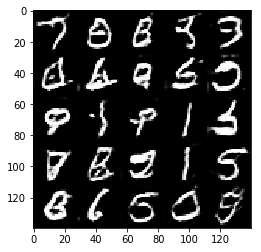

Epoch 2/2... Discriminator Loss: 1.3364... Generator Loss: 0.8148
Epoch 2/2... Discriminator Loss: 1.3397... Generator Loss: 0.8459
Epoch 2/2... Discriminator Loss: 1.3212... Generator Loss: 0.7918


In [17]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.9101
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.9398
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.8704


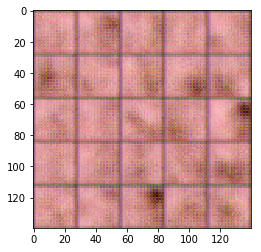

Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7886


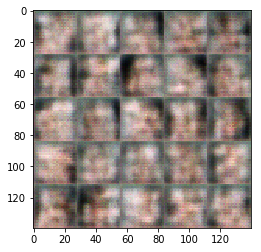

Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.8173


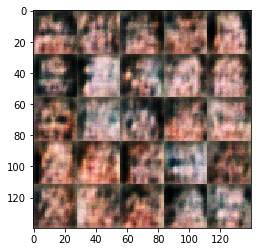

Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.8226


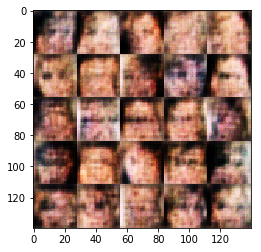

Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.8377


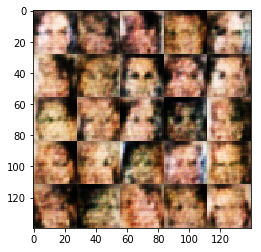

Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.8054


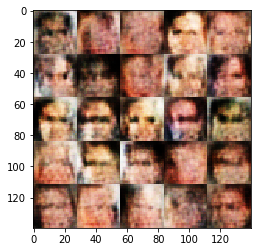

Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8030


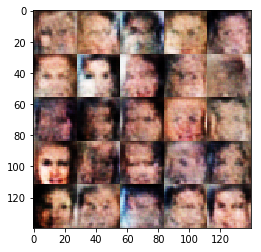

Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.8057


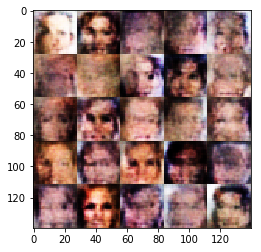

Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.8043


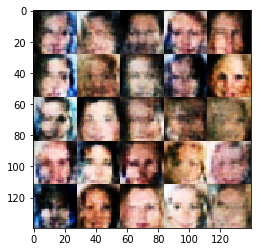

Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.8269


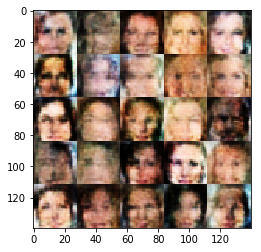

Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.8047


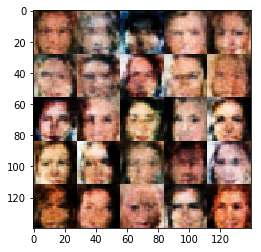

Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.8048


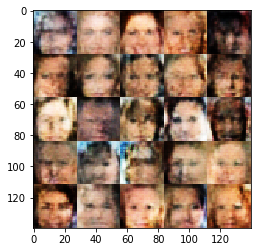

Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.8303


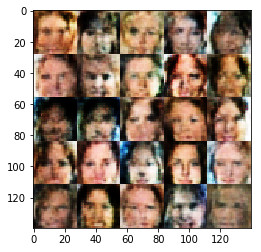

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.8324


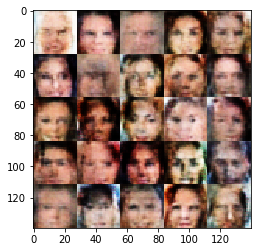

Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.7703


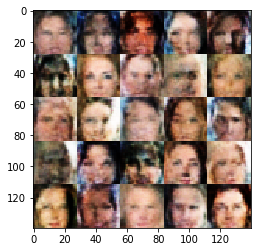

Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.7834


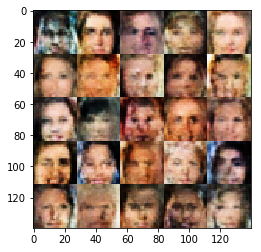

Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.8148


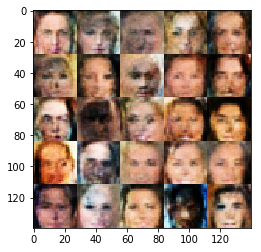

Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.7994


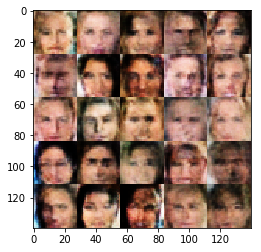

Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.8059


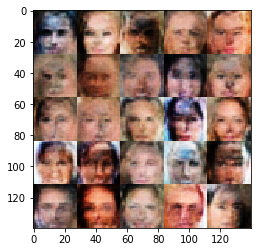

Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7587


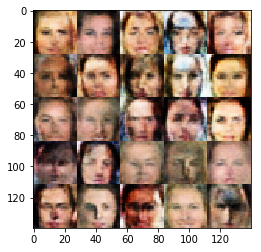

Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.8042


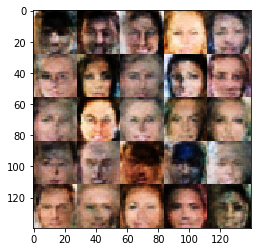

Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.8524


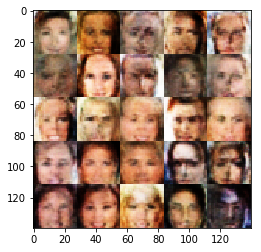

Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.7936


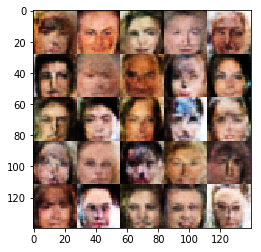

Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.8012


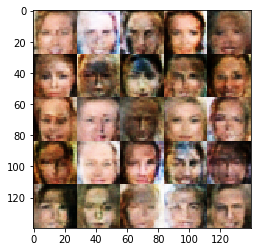

Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7931


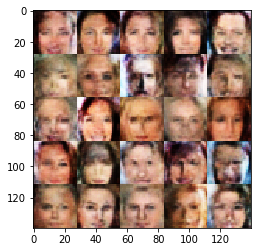

Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.8019


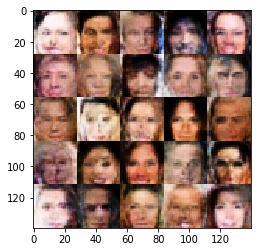

Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.8398


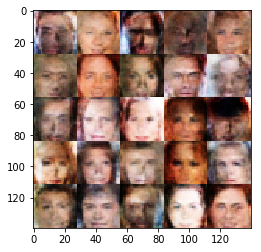

Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.8210


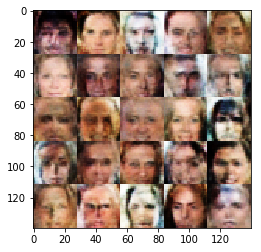

Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7731


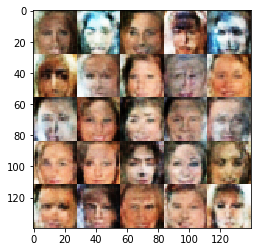

Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.8140


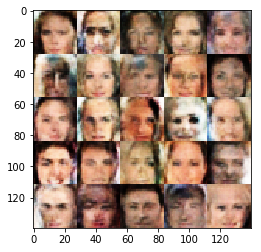

Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.8041


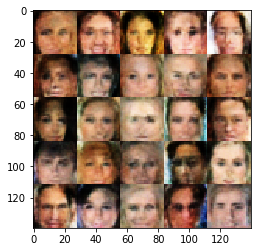

Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.8177


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.